# Optotagged waveforms
pull waveforms form kilosort files and compare between different optotagged units


In [2]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import nems0.db as nd
import nems_lbhb.baphy_io as io
# from src.root_path import config_path

#### identify phototagged cells


In [3]:
# plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])
# plt.style.use(['default', config_path / 'notebook.mplstyle'])

# config = ConfigParser()
# config.read_file(open(config_path / 'settings.ini'))

In [4]:
runclass = 'NAT'
runclass = '%'
sql = "SELECT sCellFile.*,gSingleCell.siteid,gSingleCell.phototag FROM gSingleCell " +\
      "INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid " +\
      "INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid " +\
      f"WHERE gRunClass.name like '{runclass}' AND not(isnull(phototag))"
d = nd.pd_query(sql)
d['parmfile'] = d['stimpath'] + d['stimfile']
d['animal'] = d['stimpath'].apply(lambda x: x.split('/')[-3])

[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


#### select sites and parameter files, and parses optotagging values

In [8]:
ff_tag = d.phototag.isin(['a', 's'])
tag_df = d.loc[ff_tag, ['cellid', 'phototag', 'animal']].drop_duplicates()

In [11]:
tag_df.shape

(579, 3)

#### load recordings, gets tuning curves, organizes in big array

In [46]:
def get_waveform_metrics(mwf):
    """
    powered by Charlie: Calculates spike width in ms (sw), peak-through ratio (ptr), full width half max in ms (fwhm), end slope (es)
    time to base line in ms (bs) and trough in index, all over a smoothed and normazlized waveform (wf)
    :param mwf: 1d array of waveform,
    :return: sw, prt, fwhm, bs, trough, wf
    """
    fit2 = interpolate.UnivariateSpline(np.arange(len(mwf)), mwf)
    mwf = fit2(np.linspace(0, len(mwf), 10000))
    mwf /= abs(mwf.min())
    wf = mwf
    
    #if mwf[np.argmax(np.abs(mwf))] > 0:
    #    mwf = -mwf
        
    if mwf[np.argmax(np.abs(mwf))] > 0:
        sw = ptr = fwhm = es = bs = trough = np.nan

    else:
        fs = 10000 / (82 / 30000)
        valley = np.argmin(mwf)
        peak = np.argmax(mwf[valley:]) + valley
        trough = valley

        # force 0 to be the mean of the positive waveform preceding the valley
        mi = np.argmax(mwf[:valley])
        baseline = np.mean(mwf[:mi])
        mwf -= baseline

        sw = (peak - valley) / fs * 1000  # ms

        # get fwhm (of valley)
        left = np.argmin(np.abs(mwf[:valley] - (mwf[valley] / 2)))
        right = np.argmin(np.abs(mwf[valley:] - (mwf[valley] / 2))) + valley
        fwhm = (right - left) / fs * 1000

        if mwf[peak] <= 0:
            ptr = 0
        else:
            ptr = abs(mwf[peak]) / abs(mwf[valley])

        #0.5 ms ~ 1800 bins
        #es.append((((mwf[valley + 850] - mwf[valley + 650])*fs) / (200 * fs)))
        #es.append((mwf[valley + 950] - mwf[valley + 900]) / 50)
        #es.append((mwf[valley + 1800] - mwf[valley + 1750]) / 50)
        #es.append((mwf[valley + 780] - mwf[valley + 750]))
        #es.append((mwf[valley + 2200] - mwf[valley + 900]))
        es = (mwf[valley + 550] - mwf[valley + 350])
        # save time waveform returns to baseline
        bs = np.argmin(np.abs(mwf[peak:])) / fs * 1000

    return sw, ptr, fwhm, es, bs, trough, wf


eg_waveform = io.get_mean_spike_waveform('TNC017a-09-1', 'Teonancatl', usespkfile=True)

sw, ptr, fwhm, es, bs, trough, wf = get_waveform_metrics(eg_waveform)
print(sw, ptr, fwhm, es, bs, trough)

0.5023866666666668 0.18551819089384528 0.12628 0.1683047680155227 0.6718533333333333 4935


In [47]:
print('loading all waveforms into dataframe ...')

# df_file = pl.Path(config['paths']['analysis_cache']) / '211028_waveform_summary_df'
# recache = True
# 
# if df_file.exists() and recache == False:
#     print(f'DF file found\nloading from {df_file}')
#     DF = jl.load(df_file)
# else:
DF = pd.DataFrame()
for _, row in tag_df.iterrows():
    mean_waveform = io.get_mean_spike_waveform(row.cellid, row.animal, usespkfile=True)

    if mean_waveform.size == 0:
        print(f'cant get {row.cellid} waveform')
        continue

    sw, ptr, fwhm, es, bs, trough, wf = get_waveform_metrics(mean_waveform)

    df = pd.DataFrame()
    df['cellid'] = (row.cellid,)
    df['sw'] = (sw,)
    df['ptr'] = (ptr,)
    df['fwhm'] = (fwhm,)
    df['es'] = (es,)
    df['bs'] = (bs,)
    df['trough'] = (trough,)
    df['waveform'] = (mean_waveform.tolist(),)
    df['waveform_norm'] = (wf.tolist(),)
    DF = DF.append(df, ignore_index=True)
    # jl.dump(DF, df_file)

print('done')

loading all waveforms into dataframe ...


/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done


In [48]:
d=nd.get_cell_files('TNC018a-03-5')
d

,id,cellid,masterid,rawid,celldataid,runclassid,path,resplen,repcount,respfile,...,channum,sortidx,model,stimsnr,area,goodtrials,respZ,respSNR,name,isolation
0,160562,TNC018a-03-5,45727,144226,0,51,/auto/data/daq/Teonancatl/TNC018/sorted/,6082560,2,TNC018a20_p_NON.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,NON,100.0
1,160661,TNC018a-03-5,45727,144227,0,1,/auto/data/daq/Teonancatl/TNC018/sorted/,6142976,2,TNC018a21_p_TOR.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,TOR,100.0
2,160760,TNC018a-03-5,45727,144228,0,1,/auto/data/daq/Teonancatl/TNC018/sorted/,5765120,2,TNC018a22_p_TOR.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,TOR,100.0
3,160859,TNC018a-03-5,45727,144229,0,65,/auto/data/daq/Teonancatl/TNC018/sorted/,5540864,60,TNC018a23_p_BNB.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,BNB,100.0
4,160958,TNC018a-03-5,45727,144230,0,2,/auto/data/daq/Teonancatl/TNC018/sorted/,7538688,6,TNC018a24_p_FTC.spk.mat,...,3,1,0,1000,A1,,0.0,0.0,FTC,100.0


In [49]:
DF.loc[DF.cellid=='TNC018a-03-5']

,cellid,sw,ptr,fwhm,es,bs,trough,waveform,waveform_norm
525,TNC018a-03-5,0.230693,0.257831,0.157167,0.400173,0.96842,4932.0,"(8.680877412615978, 7.497912173739101, 4.75271...","(0.006005972278935233, 0.005982960918519372, 0..."


In [50]:
DF.shape, tag_df.shape

((579, 9), (579, 3))

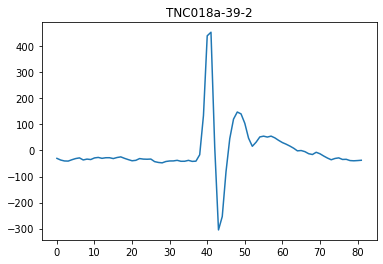

In [51]:
merge = pd.merge(DF, tag_df, how='inner', on='cellid', validate='1:1')
bad=merge.loc[np.isnan(merge.sw)]
plt.figure()
plt.plot(bad.iloc[8]['waveform'])
plt.title(bad.iloc[8]['cellid']);

In [52]:
merge = pd.merge(DF, tag_df, how='inner', on='cellid', validate='1:1').dropna()
merge.shape

(529, 11)

In [53]:
bad

,cellid,sw,ptr,fwhm,es,bs,trough,waveform,waveform_norm,phototag,animal
85,TNC017a-30-3,NaN,NaN,NaN,NaN,NaN,NaN,"(20.697993767538673, 12.132017616226626, 10.65...","(0.11640589815555596, 0.11582768819256989, 0.1...",s,Teonancatl
453,TNC009a-41-3,NaN,NaN,NaN,NaN,NaN,NaN,"(-28.28468167486775, -28.46279548655899, -30.2...","(-0.5651280109828521, -0.5650621601064953, -0....",s,Teonancatl
454,TNC009a-63-1,NaN,NaN,NaN,NaN,NaN,NaN,"(-16.855030620263868, -23.889484138970538, -27...","(-0.44803861886559826, -0.4495600519201964, -0...",s,Teonancatl
455,TNC009a-09-1,NaN,NaN,NaN,NaN,NaN,NaN,"(-22.951896781415897, -23.663802357965977, -35...","(-0.5341806382653086, -0.5316932346055524, -0....",s,Teonancatl
457,TNC009a-15-1,NaN,NaN,NaN,NaN,NaN,NaN,"(9.512421344193516, 10.625209691345983, 10.449...","(0.06597612185538822, 0.06594026697512728, 0.0...",s,Teonancatl
518,TNC008a-33-1,NaN,NaN,NaN,NaN,NaN,NaN,"(3.0176692662377733, 0.05551408574443535, -0.1...","(0.014356037459655758, 0.014239896060536604, 0...",s,Teonancatl
523,TNC018a-03-3,NaN,NaN,NaN,NaN,NaN,NaN,"(-43.31578183169092, -38.45399826621038, -34.7...","(-0.26391723663698385, -0.2637078436081522, -0...",s,Teonancatl
532,TNC018a-10-4,NaN,NaN,NaN,NaN,NaN,NaN,"(-17.992872567137667, -16.814310710417132, -14...","(-0.12211253709133639, -0.12188085454603885, -...",s,Teonancatl
570,TNC018a-39-2,NaN,NaN,NaN,NaN,NaN,NaN,"(-30.441155849752285, -36.84419711729809, -40....","(-0.09486708843384896, -0.09502078721586242, -...",a,Teonancatl


# Waveform analysis
## activated neurons

In [54]:
csw = merge['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
cptr = merge['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
ces = merge['es'].values
wf = merge['waveform_norm'].values
trough = merge['trough'].values

X = np.vstack((csw, cptr, ces)).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
gmm = GaussianMixture(n_components=2).fit(X)
merge['labels'] = gmm.predict(X)
merge['wshape'] = ""
test_width = merge.groupby('labels')['sw'].mean()
if test_width.loc[0]>test_width.loc[1]:
    merge.loc[merge['labels']==0,'wshape']='RS'
    merge.loc[merge['labels']==1,'wshape']='NS'
else:
    merge.loc[merge['labels']==0,'wshape']='NS'
    merge.loc[merge['labels']==1,'wshape']='RS'
   
merge.drop(columns=['waveform_norm']).to_csv('phototag_waveform_labels.csv')

In [55]:
test_width = merge.groupby('wshape')['sw'].mean()
test_width

wshape
NS    0.298987
RS    0.722372
Name: sw, dtype: float64

In [56]:
merge.groupby(['phototag','labels']).count()


cellid   sw  ptr  fwhm   es   bs  trough  waveform  \
phototag labels                                                       
a        0           18   18   18    18   18   18      18        18   
         1           29   29   29    29   29   29      29        29   
s        0          395  395  395   395  395  395     395       395   
         1           87   87   87    87   87   87      87        87   

                 waveform_norm  animal  wshape  
phototag labels                                 
a        0                  18      18      18  
         1                  29      29      29  
s        0                 395     395     395  
         1                  87      87      87

In [75]:
merge.loc[(merge.cellid.str.startswith("TNC018a-0")),['cellid','labels','wshape','sw','phototag']].sort_values(by=['cellid'])

,cellid,labels,wshape,sw,phototag
293,TNC018a-01-1,0,RS,0.757680,s
521,TNC018a-01-2,0,RS,0.791027,s
292,TNC018a-03-1,1,NS,0.235340,s
2,TNC018a-03-2,1,NS,0.270600,s
524,TNC018a-03-4,0,RS,0.777907,s
525,TNC018a-03-5,1,NS,0.230693,s
291,TNC018a-04-1,1,NS,0.335380,s
3,TNC018a-04-2,1,NS,0.318160,s
290,TNC018a-05-2,0,RS,0.682240,s
4,TNC018a-05-3,0,RS,0.648620,s


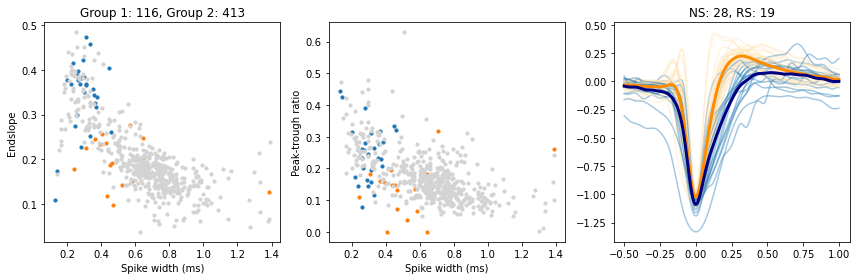

In [60]:
toplot = merge.loc[merge.phototag == 'a', ['cellid', 'sw', 'ptr', 'es', 'waveform_norm', 'trough']].dropna(axis=0)

csw = toplot['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
cptr = toplot['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
ces = toplot['es'].values
wf = toplot['waveform_norm'].values
trough = toplot['trough'].values

X = np.vstack((csw, cptr, ces)).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
gmm = GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)


f, ax = plt.subplots(1, 3, figsize=(12, 4))

_i = (merge['phototag']=='s')
_i1 = (merge['labels'] == 1) & (merge['phototag']=='a')
_i0 = (merge['labels'] == 0) & (merge['phototag']=='a')
ax[0].scatter(merge.loc[_i1,'sw'], merge.loc[_i1,'es'], s=10)
ax[0].scatter(merge.loc[_i0,'sw'], merge.loc[_i0,'es'], s=10)
ax[0].scatter(merge.loc[_i,'sw'], merge.loc[_i,'es'], s=10, color='lightgray')
ax[0].set_xlabel('Spike width (ms)')
ax[0].set_ylabel('Endslope')
ax[0].set_title(f"Group 1: {sum(merge['labels'] == 1)}, Group 2: {sum(merge['labels'] == 0)}")

ax[1].scatter(merge.loc[_i1,'sw'], merge.loc[_i1,'ptr'], s=10)
ax[1].scatter(merge.loc[_i0,'sw'], merge.loc[_i0,'ptr'], s=10)
ax[1].scatter(merge.loc[_i,'sw'], merge.loc[_i,'ptr'], s=10, color='lightgray')
ax[1].set_xlabel('Spike width (ms)')
ax[1].set_ylabel('Peak-trough ratio')

centered = []
fs = 10000 / (82 / 30000)
for w, wave in enumerate(wf):
    wave = np.asarray(wave)
    t = int(trough[w])
    wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
    time = np.linspace(-.5, 1, wave.shape[0])

    if labels[w] == 0:
        color = 'moccasin'
    else:
        color = 'tab:blue'
    centered.append(wave)
    ax[2].plot(time, wave, color=color, alpha=0.4)

ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

# categorize as NS / RS -- force Narrow to be label==1
if csw[labels == 1].mean() < csw[labels == 0].mean():
    ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
else:
    ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

f.tight_layout()

plt.show()

## suppresed neurons

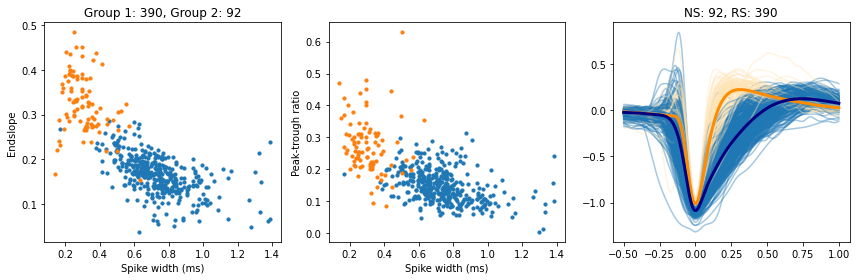

In [61]:
toplot = merge.loc[merge.phototag == 's', ['cellid', 'sw', 'ptr', 'es', 'waveform_norm', 'trough']].dropna(axis=0)

csw = toplot['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
cptr = toplot['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
ces = toplot['es'].values
wf = toplot['waveform_norm'].values
trough = toplot['trough'].values

X = np.vstack((csw, cptr, ces)).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
gmm = GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)
f, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(csw[labels == 1], ces[labels == 1], s=10)
ax[0].scatter(csw[labels == 0], ces[labels == 0], s=10)
ax[0].set_xlabel('Spike width (ms)')
ax[0].set_ylabel('Endslope')
ax[0].set_title(f"Group 1: {sum(labels == 1)}, Group 2: {sum(labels == 0)}")

ax[1].scatter(csw[labels == 1], cptr[labels == 1], s=10)
ax[1].scatter(csw[labels == 0], cptr[labels == 0], s=10)
ax[1].set_xlabel('Spike width (ms)')
ax[1].set_ylabel('Peak-trough ratio')

centered = []
fs = 10000 / (82 / 30000)
for w, wave in enumerate(wf):
    wave = np.asarray(wave)
    t = int(trough[w])
    wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
    time = np.linspace(-.5, 1, wave.shape[0])

    if labels[w] == 0:
        color = 'moccasin'
    else:
        color = 'tab:blue'
    centered.append(wave)
    ax[2].plot(time, wave, color=color, alpha=0.4)

ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

# categorize as NS / RS -- force Narrow to be label==1
if csw[labels == 1].mean() < csw[labels == 0].mean():
    ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
else:
    ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

f.tight_layout()

plt.show()